In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from FeatureEngeneering import CreateNewFeatures
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import  StandardScaler
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import Ridge, HuberRegressor


In [10]:
# Read csv file and create dataframe
df = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')
df.head()

,id,Row#,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds,yield
0,0,104.0,12.5,0.25,0.25,0.25,0.75,69.7,42.1,58.2,50.2,24.3,41.2,16.00,0.26,0.477941,0.423927,34.043022,6079.08526
1,1,764.0,25.0,0.00,0.00,0.00,0.00,86.0,52.0,71.9,62.0,30.0,50.8,3.77,0.06,0.334594,0.354415,27.735098,2946.92602
2,2,621.0,25.0,0.50,0.25,0.75,0.63,86.0,52.0,71.9,62.0,30.0,50.8,34.00,0.56,0.468192,0.417915,34.838815,5323.30034
3,3,499.0,25.0,0.50,0.25,0.38,0.75,69.7,42.1,58.2,50.2,24.3,41.2,24.00,0.39,0.500558,0.427431,35.134955,6157.05484
4,4,439.0,12.5,0.25,0.38,0.50,0.75,77.4,46.8,64.7,55.8,27.0,45.8,24.00,0.39,0.520181,0.464067,37.029180,6992.82314


<Axes: >

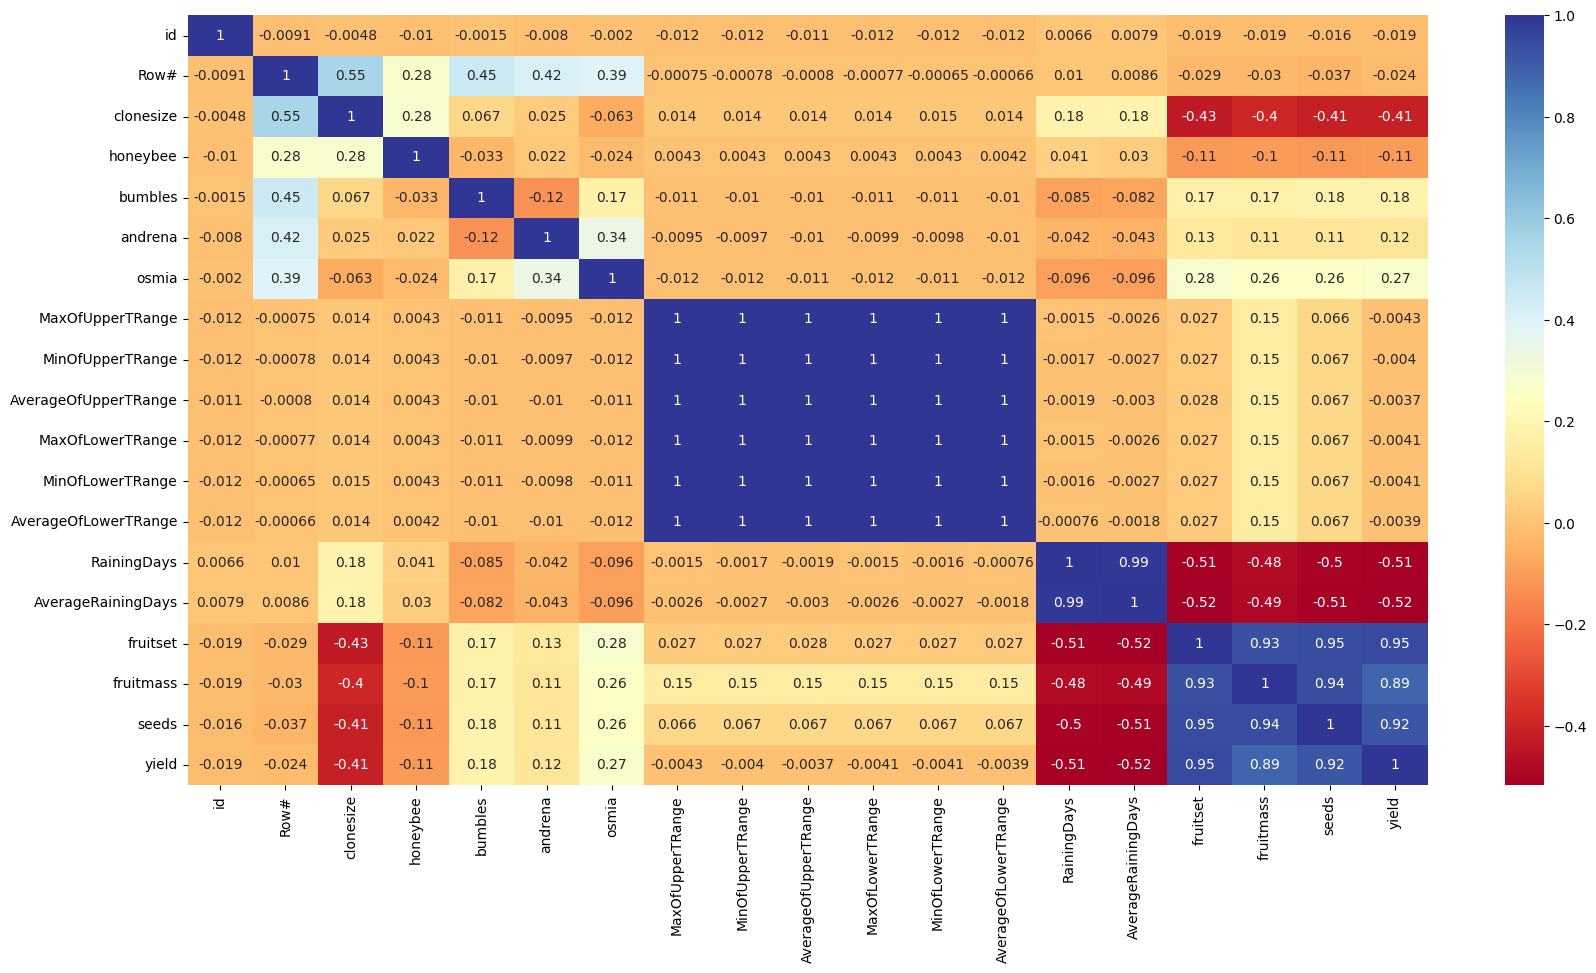

In [11]:
# Hitmap 
plt.subplots(figsize=(20,10))
sns.heatmap(df.corr(),annot=True, cmap="RdYlBu")

In [12]:
# Create New Features to train and test
df = CreateNewFeatures(df)
test = CreateNewFeatures(test)

<Axes: >

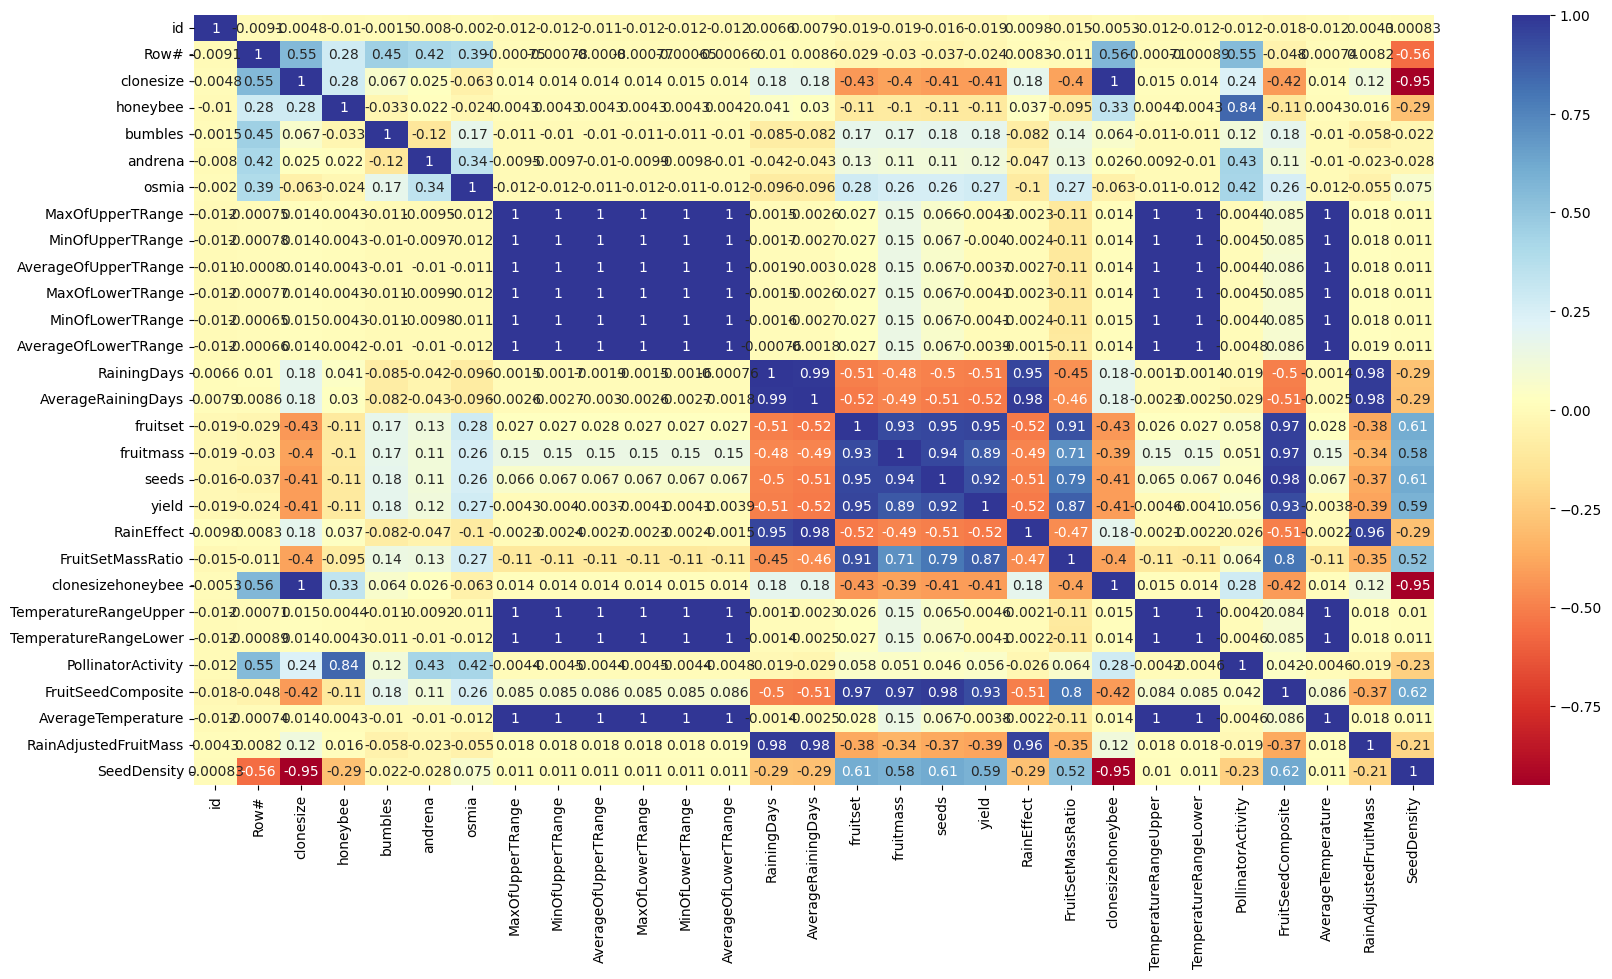

In [13]:
# Hitmap after adding new features
plt.subplots(figsize=(20,10))
sns.heatmap(df.corr(),annot=True, cmap="RdYlBu")

# Sample Model

In [14]:

X = df.drop(columns= ['id','yield'])
test = test.drop(columns=['id'])
y = df['yield']


# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest model
model_1 = RandomForestRegressor(
        criterion='absolute_error',
        min_samples_split=6,
        min_samples_leaf=10,
        n_estimators=100,
        max_depth=19,
        bootstrap=True,
        random_state=42,
        n_jobs=-1)
model_1.fit(X_train, y_train)


model_1.fit(X_train,y_train)
y_prob1 = model_1.predict(X_test)

print(mean_absolute_error(y_test,y_prob1))

sub = model_1.predict(test)

241.76774165588333


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|===================| 11954/12000 [03:11<00:00]        

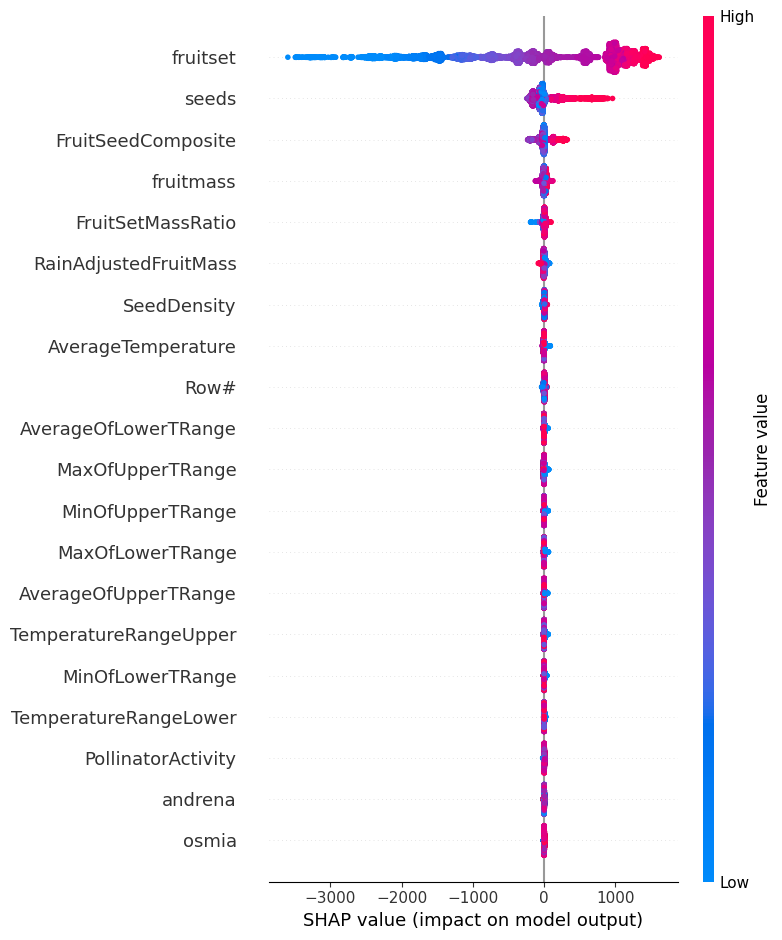

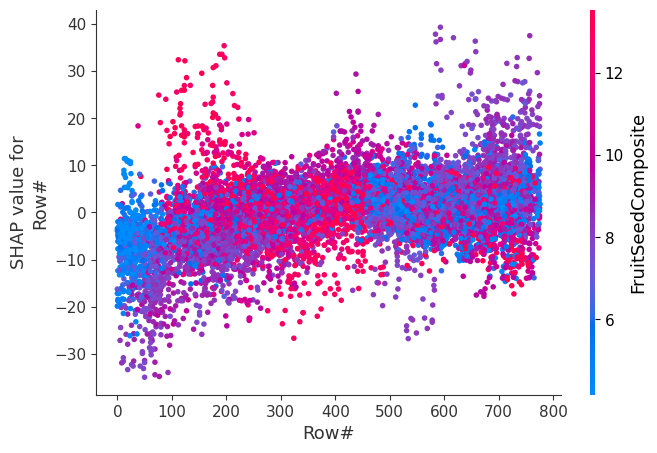

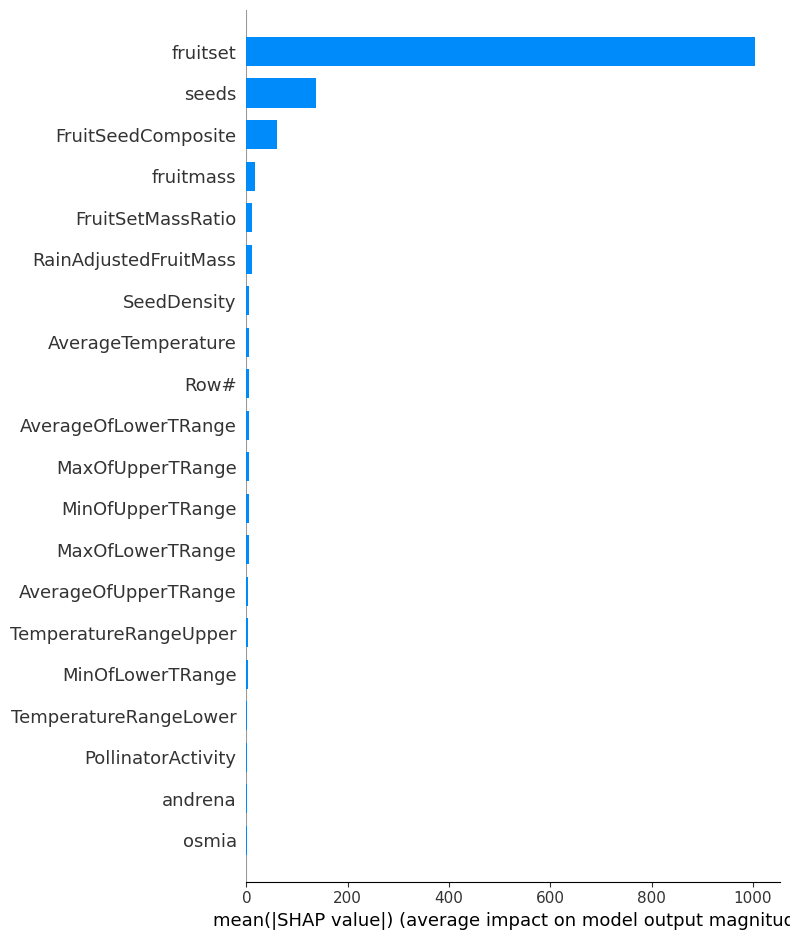

In [15]:
import shap

explainer = shap.Explainer(model_1, X_train)

# Compute SHAP values
shap_values = explainer(X_train)

# Summary Plot
shap.summary_plot(shap_values, X_train)

# Dependence Plot (example for the first feature)
shap.dependence_plot(0, shap_values.values, X_train)

# Bar Plot (Feature Importance)
shap.summary_plot(shap_values, X_train, plot_type="bar")


In [16]:
"""import optuna
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import pandas as pd


# Define the objective function for Optuna
def objective(trial):
    # Hyperparameters to tune
    n_estimators = trial.suggest_int("n_estimators", 50, 300)
    criterion = trial.suggest_categorical("criterion", ["squared_error", "absolute_error"])
    max_depth = trial.suggest_int("max_depth", 5, 30)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 20)
    min_weight_fraction_leaf = trial.suggest_float("min_weight_fraction_leaf", 0.0, 0.5)
    max_features = trial.suggest_float("max_features", 0.1, 1.0)
    max_leaf_nodes = trial.suggest_int("max_leaf_nodes", 10, 1000)
    min_impurity_decrease = trial.suggest_float("min_impurity_decrease", 0.0, 0.1)
    bootstrap = trial.suggest_categorical("bootstrap", [True, False])
    oob_score = trial.suggest_categorical("oob_score", [True, False]) if bootstrap else False
    ccp_alpha = trial.suggest_float("ccp_alpha", 0.0, 0.1)
    max_samples = trial.suggest_float("max_samples", 0.5, 1.0) if bootstrap else None

    # Initialize the model with the suggested hyperparameters
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        criterion=criterion,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        min_weight_fraction_leaf=min_weight_fraction_leaf,
        max_features=max_features,
        max_leaf_nodes=max_leaf_nodes,
        min_impurity_decrease=min_impurity_decrease,
        bootstrap=bootstrap,
        oob_score=oob_score,
        random_state=42,
        ccp_alpha=ccp_alpha,
        max_samples=max_samples
    )

    # Cross-validate and minimize the negative mean absolute error
    score = cross_val_score(model, X_train, y_train, cv=5, scoring="neg_mean_absolute_error")
    mean_score = score.mean()
    return mean_score

# Create a study and optimize
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# Output the best parameters and score
print("Best hyperparameters: ", study.best_params)
print("Best score (MAE): ", -study.best_value)  # Negate because scores are negative"""

'import optuna\nfrom sklearn.ensemble import RandomForestRegressor\nfrom sklearn.model_selection import train_test_split, cross_val_score\nfrom sklearn.metrics import mean_squared_error\nfrom sklearn.preprocessing import StandardScaler\nimport pandas as pd\n\n\n# Define the objective function for Optuna\ndef objective(trial):\n    # Hyperparameters to tune\n    n_estimators = trial.suggest_int("n_estimators", 50, 300)\n    criterion = trial.suggest_categorical("criterion", ["squared_error", "absolute_error"])\n    max_depth = trial.suggest_int("max_depth", 5, 30)\n    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)\n    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 20)\n    min_weight_fraction_leaf = trial.suggest_float("min_weight_fraction_leaf", 0.0, 0.5)\n    max_features = trial.suggest_float("max_features", 0.1, 1.0)\n    max_leaf_nodes = trial.suggest_int("max_leaf_nodes", 10, 1000)\n    min_impurity_decrease = trial.suggest_float("min_impurity_dec

# Stacking Model


In [ ]:

# Base model 1: Huber Regressor with StandardScaler
base_model_1 = Pipeline([
    ('scaler', StandardScaler()),
    ('huber', Ridge())
])

# Base model 2: Random Forest Regressor (no scaling)
base_model_2 = RandomForestRegressor(  min_samples_split=6,
        criterion='absolute_error',
        min_samples_leaf=10,
        n_estimators=100,
        max_depth=19,
        max_features='sqrt',
        bootstrap=True,
        random_state=42,
        n_jobs=-1)
# Base model 3: Random Forest Regressor (no scaling)
base_model_3 = DecisionTreeRegressor(criterion= 'friedman_mse',
        min_samples_split=6,
        min_samples_leaf=10,
        max_depth=19,
        max_features='sqrt',
        random_state=42,
        )



# Meta-model: Ridge Regression with StandardScaler
meta_model = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', HuberRegressor())
])

# Stacking Regressor (using base models and meta-model)
stacked_model = StackingRegressor(
    estimators=[('huber', base_model_1), ('rf', base_model_2),('linear',base_model_3)],
    final_estimator=meta_model
)

# Fit the stacked model
stacked_model.fit(X_train, y_train)

# Make predictions
y_pred = stacked_model.predict(X_test)

# Evaluate the model using Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae:.2f}")


In [ ]:
stacked_model.fit(X,y)
sub = stacked_model.predict(test)

In [ ]:

submission['yield'] = sub

submission.to_csv('my_submission.csv',index=False)

submission

,id,yield
0,15000,5506.654354
1,15001,6637.099998
2,15002,4587.125229
3,15003,6230.854635
4,15004,6972.769580
...,...,...
9995,24995,4592.651502
9996,24996,5555.858254
9997,24997,5983.863510
9998,24998,5560.096375
